# Making a model

As illustrated in the architecture page, SATLAS2 is built on the concept of a Fitter object, to which Source objects are assigned. These Source objects contain both experimental data, but are also assigned one or more Models, which should be fitted to the data.

The base aspect of these Models is that two things should be implemented: a *params* attribute which is a dictionary containing all the Parameters that the Model needs, and a method *f(x)*, where the response for the given *x* values is returned. It is recommended that the first line of the method is *x = self.transform(x)* in order to correctly handle any transformation functions that are required.

In this tutorial, a new Model will be created to model a sine wave with exponential damping called *ExpSine*, just as an example. In the preamble, we just import all the libraries that we will need.

In [1]:
import sys

sys.path.insert(0, '..\src')
import matplotlib.pyplot as plt
import numpy as np

import satlas2

The new class will be a subclass of the SATLAS2 Model class, and it will contain SATLAS2 Parameters in its *params* dictionary.

In [2]:
class ExpSine(satlas2.Model):
    def __init__(self, A, lamda, omega, name='ExpSine', prefunc=None):
        super().__init__(name, prefunc=prefunc)
        self.params={
            'amplitude': satlas2.Parameter(value=A,min=0,max=np.inf,vary=True),
            'lambda': satlas2.Parameter(value=lamda, min=0, max=np.inf, vary=True),
            'omega': satlas2.Parameter(value=omega, min=0, max=np.inf, vary=True)
        }
    
    def f(self, x):
        x = self.transform(x)
        a = self.params['amplitude'].value
        l = self.params['lambda'].value
        o = self.params['omega'].value
        return a*np.exp(-l*x)*np.sin(o*x)

This defines a sine wave of angular frequency ω with an exponential decay with decay constant λ. Note that, in the parameter name in *__init__*, *lamda* is used instead of *lambda* since the last one is a keyword in Python.

With this new Model, we can use this to both simulate what a dataset would look like:

{'amplitude': 7+/-0 (inf max, 0 min, vary=True, correl={}),
 'lambda': 1.5+/-0 (inf max, 0 min, vary=True, correl={}),
 'omega': 4+/-0 (inf max, 0 min, vary=True, correl={})}

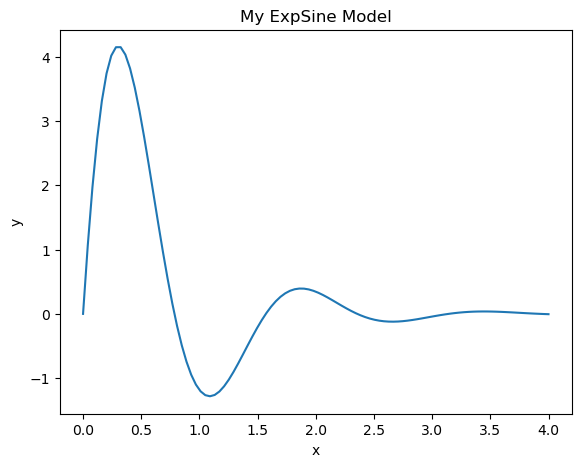

In [3]:
amplitude = 7
lamda = 1.5
omega = 4
model = ExpSine(amplitude, lamda, omega, name='MyModel')

x = np.linspace(0, 4, 100)
y = model.f(x)

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(x, y)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('My ExpSine Model')
model.params

And this model can easily be used with Source and Fitter to fit to data. First, we generate some data:

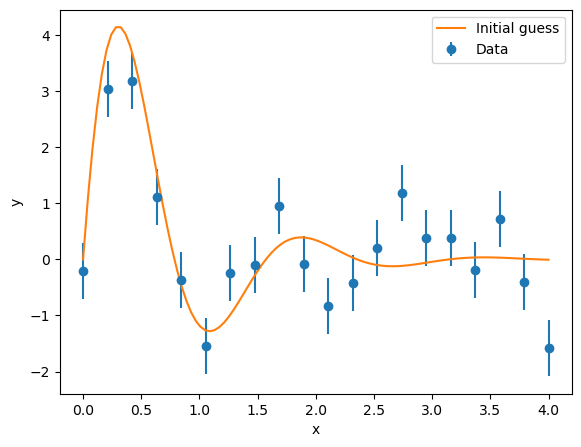

In [4]:
data_x = np.linspace(0, 4, 20)
data_y = model.f(data_x) + np.random.randn(data_x.shape[0])*0.5
yerr = np.ones(data_y.shape)*0.5

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.errorbar(data_x, data_y, yerr=yerr, fmt='o', label='Data')
ax.plot(x, y, label='Initial guess')
ax.set_xlabel('x')
ax.set_ylabel('y')
_ = ax.legend(loc=0)

We assign this data to a Source, add the ExpSine model to this Source, and pass it to a Fitter to fit this. Since this requires a normal chisquare fit, no extra arguments are required for the fit.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 53
    # data points      = 20
    # variables        = 3
    chi-square         = 28.7327890
    reduced chi-square = 1.69016406
    Akaike info crit   = 13.2461335
    Bayesian info crit = 16.2333303
[[Variables]]
    Datafile1___MyModel___amplitude:  5.39734439 +/- 1.20120658 (22.26%) (init = 7)
    Datafile1___MyModel___lambda:     1.36883125 +/- 0.40630320 (29.68%) (init = 1.5)
    Datafile1___MyModel___omega:      4.44140916 +/- 0.25391170 (5.72%) (init = 4)


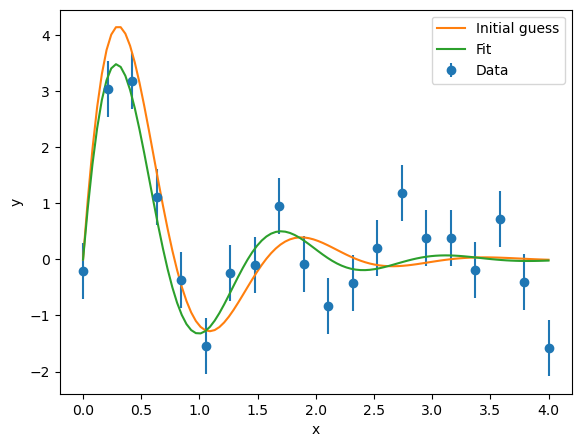

In [5]:
datasource = satlas2.Source(data_x, data_y, yerr=yerr, name='Datafile1')
datasource.addModel(model)
f = satlas2.Fitter()
f.addSource(datasource)
f.fit()
print(f.reportFit())
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.errorbar(data_x, data_y, yerr=yerr, fmt='o', label='Data')
ax.plot(x, y, label='Initial guess')
ax.plot(x, model.f(x), label='Fit')
ax.set_xlabel('x')
ax.set_ylabel('y')
_ = ax.legend(loc=0)